# Step 1: Loading and Displaying the Images

### Objective:
- Load images in grayscale format for simplicity.
- Ensure they are properly read into a consistent resolution.
- Display the images to verify successful loading.

### Implementation:
- Use the **Pillow** library for image handling.
- Convert images to grayscale during loading.
- Resize all images to the same resolution (`512×512`) for uniform processing.
- Visualize a few images using **matplotlib**.

In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict, Counter
from scipy.fftpack import dct, idct

In [4]:
# Path to the images
t = 1
image_file_path = f"/home/ssaral/Downloads/CS663_Project/img/kodim{t:02d}.png"
reconstructed_filename = f"reconstructed_kodim{t:02d}.png"
plot_filename = f"rmse_bpp_kodim{t:02d}.png"

# Function to load images in grayscale
def load_images(image_file_path, target_size=(512, 512)):
    # images = []
    img = Image.open(image_file_path).convert("L")  # Convert to grayscale
    img = img.resize(target_size)  # Resize to target size
    # images.append(np.array(img))
    return np.array(img)

# Load images
images = load_images(image_file_path)
print(images.shape)

(512, 512)


## Displaying Original Image and Rescaled Image in Grayscale

Image info: Mode: RGB, Size: 768x512, Bit depth: N/A


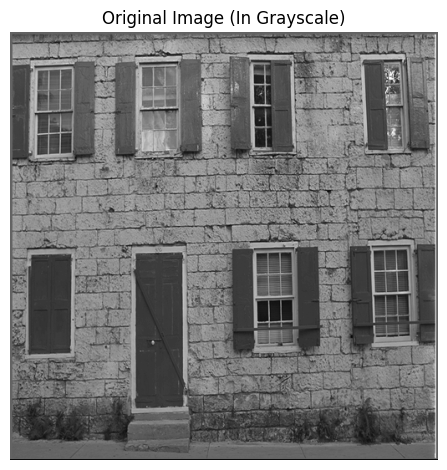

Image info: Mode: L (Grayscale), Size: 512x512, Bit depth: 8


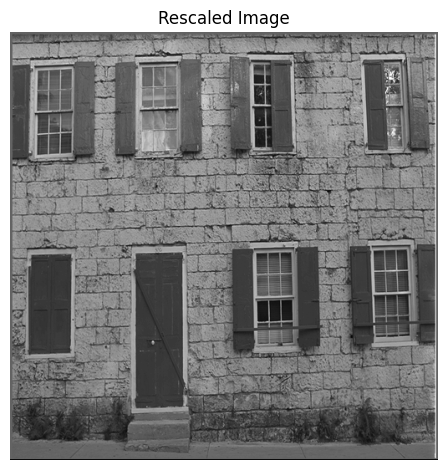

In [5]:
# Displaying original image information
def display_image_info(image_path):
    try:
        img = Image.open(image_path)
        mode = img.mode # mode=(RGB:color_images, L:grayscale)
        size = img.size # size=(width, height)
        bit_depth = img.bits if hasattr(img, 'bits') else 'N/A' # bit depth=(8-bit for "L", 24-bit for "RGB")
        return f"Mode: {mode}, Size: {size[0]}x{size[1]}, Bit depth: {bit_depth}"
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return "Error loading image"

# Display a few images to verify
# plt.figure(figsize=(12, 6))
plt.imshow(images, cmap="gray")
plt.title(f"Original Image (In Grayscale)")
plt.axis("off")  
image_info = display_image_info(image_file_path)
print(f"Image info: {image_info}")
plt.tight_layout()
plt.show()


def display_image_info_from_array(image_array):
    # Checking the image mode is grayscale (mode 'L' in PIL corresponds to single channel)
    if len(image_array.shape) == 2:
        mode = 'L (Grayscale)'
        bit_depth = 8  
    elif len(image_array.shape) == 3 and image_array.shape[2] == 3:
        mode = 'RGB (Color)'
        bit_depth = 24 
    else:
        mode = 'Unknown'
        bit_depth = 'N/A'
        
    size = image_array.shape[:2]  # first two dimensions (height, width)
    return f"Mode: {mode}, Size: {size[1]}x{size[0]}, Bit depth: {bit_depth}"

# plt.figure(figsize=(12, 6))
plt.imshow(images, cmap="gray")
plt.title(f"Rescaled Image")
plt.axis("off")
image_info = display_image_info_from_array(images)
print(f"Image info: {image_info}")
plt.tight_layout()
plt.show()

# Step 2: Divide Images into 8×8 Blocks and Compute 2D DCT

### Objective:
- Divide each image into non-overlapping `8×8` blocks.
- Compute the 2D DCT for each block.

### Details:
- We have used the `scipy.fftpack.dct` function to compute the DCT.
- The **2D DCT** is applied block-wise to all `8×8` blocks.
- The resulting **DCT coefficients** will serve as the compressed representation of the block.

### Implementation Steps:
1. Divide each image into `8×8` blocks.
2. Apply the **2D DCT** to each block.
3. Store the transformed coefficients for further processing.

In [6]:
# divide an image into 8x8 blocks
def divide_into_blocks(image, block_size=8):
    h, w = image.shape
    assert h % block_size == 0 and w % block_size == 0, "Image dimensions must be divisible by block size."
    blocks = []
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            blocks.append(block)
    return np.array(blocks)

# compute 2D DCT for each block
def compute_dct(blocks):
    dct_blocks = []
    for block in blocks:
        dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
        dct_blocks.append(dct_block)
    return np.array(dct_blocks)

# Process all images
blocks = divide_into_blocks(images)  # Divide into 8x8 blocks
dct_blocks = compute_dct(blocks)  # Compute DCT for each block
# print(f"{dct_blocks}")
print(dct_blocks.shape)

(4096, 8, 8)


## Visualizing few DCT block value

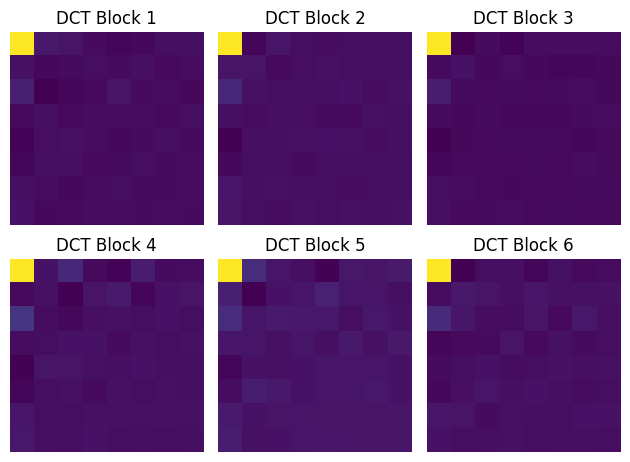

In [7]:
# Display the first few DCT blocks
# plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(dct_blocks[i])#, cmap="gray")
    plt.title(f"DCT Block {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Step 3: Quantization of DCT Coefficients

Quantization is a critical step in JPEG compression where the DCT coefficients are compressed by reducing their precision. This step helps reduce the size of the image by retaining the most significant coefficients while discarding less important ones.

### JPEG Quantization Table
JPEG uses standard `8×8` quantization tables for luminance and chrominance. We'll focus on luminance since we are working with grayscale images.

#### Default Luminance Quantization Table
The luminance quantization table \( T \) is given by:

T = 
\begin{bmatrix}
  16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 \\
  12 & 12 & 14 & 19 & 26 & 58 & 60 & 55 \\
  14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 \\
  14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 \\
  24 & 35 & 55 & 64 & 81 & 104 & 103 & 77 \\
  49 & 64 & 78 & 87 & 103 & 121 & 120 & 101 \\
  72 & 92 & 95 & 98 & 112 & 100 & 103 & 99 \\
  87 & 110 & 120 & 103 & 113 & 122 & 120 & 111
\end{bmatrix}

This table is used to quantize the DCT coefficients, with larger values indicating coefficients that should be retained with more precision and smaller values representing less significant coefficients that can be discarded to achieve compression.

In [8]:
# Default quantization table
default_quantization_table = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# For scaling quantization table by quality factor
def scale_quantization_table(table, quality_factor):
    if quality_factor < 1: quality_factor = 1
    if quality_factor > 100: quality_factor = 100
    scale = 50 / quality_factor if quality_factor < 50 else (100 - quality_factor) / 50
    scaled_table = np.clip(np.round(table * scale), 1, 255)  # Ensuring the values stay within [1, 255]
    return scaled_table

# Function to quantize DCT coefficients
def quantize_dct(dct_blocks, quant_table):
    quantized_blocks = []
    for block in dct_blocks:
        quantized_block = np.round(block / quant_table).astype(int)  # Quantize
        quantized_blocks.append(quantized_block)
    return np.array(quantized_blocks)

quality_factor = 50  # For adjusting quality factor
scaled_table = scale_quantization_table(default_quantization_table, quality_factor)

quantized_blocks = quantize_dct(dct_blocks, scaled_table)
print(quantized_blocks.shape)

(4096, 8, 8)


## Visualizing few Quantaized DCT block value

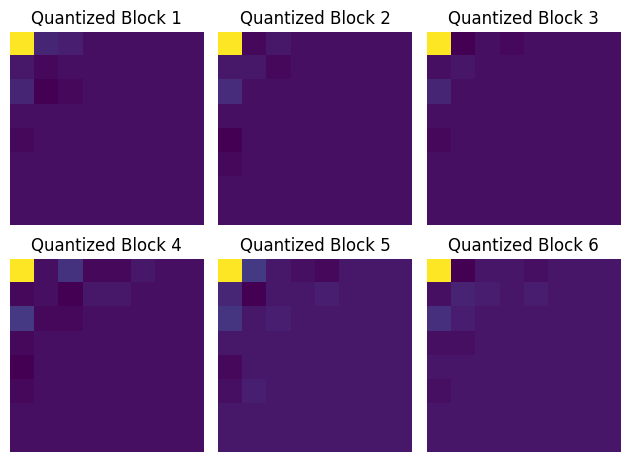

In [9]:
# Display first few quantized blocks for verification
# plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(quantized_blocks[i]) #, cmap="gray")
    plt.title(f"Quantized Block {i + 1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Difference between DCT block and Quantized DCT Block (1 sample)

In [10]:
print(f"{dct_blocks[0]} \n {quantized_blocks[0]}")

[[ 7.43875000e+02  2.82963749e+01  1.73399806e+01 -2.06404089e+00
  -1.01250000e+01 -8.81415278e+00  7.56513858e+00  5.81404464e+00]
 [ 1.04802127e+01 -7.22904002e+00 -2.89119316e+00  2.94201585e+00
  -3.14796971e+00  7.46475929e+00 -5.56416153e+00  5.76599889e-01]
 [ 4.20729889e+01 -2.43904460e+01 -1.41291261e+01 -3.45929347e+00
   1.68848400e+01 -6.72634110e-01  8.54631137e-01 -9.18108150e+00]
 [-3.39807566e+00  5.89063024e+00 -5.20583215e+00  2.10692286e+00
   4.24318748e-01  1.88782063e-01 -4.10766340e+00  4.35743154e+00]
 [-1.63750000e+01  5.43502782e+00  1.08632085e+01  2.60612583e+00
  -9.37500000e+00 -2.54101197e+00  5.64773859e+00 -3.86443912e-01]
 [-1.02206394e+01  4.75652949e+00  7.02735315e+00 -4.45550905e+00
  -2.24197594e+00  3.59802843e+00 -2.16355895e+00  9.66009038e-01]
 [ 6.52072480e+00 -2.52758071e-01 -7.39536886e+00  4.46278207e-01
   4.50648741e+00 -1.81720223e+00 -8.70873926e-01  1.30555177e+00]
 [ 1.26478952e+01 -8.56769123e+00 -4.09568262e+00  2.45986191e+00
   

In [10]:
# for block in quantized_blocks:
#         print(block.flatten())

# Step 4: Implement Huffman Encoding

1. **Flatten all `8×8` blocks** into a 1D array of quantized coefficients.
2. **Calculate the frequency** of each unique value.
3. **Construct the Huffman tree** based on these frequencies.
4. **Generate the Huffman codes**.
5. **Encode the quantized coefficients** into a bitstream.

# How Huffman Encoding Works

### Input: 
A sequence of symbols (e.g., quantized DCT coefficients).

### Frequency Analysis:
- Compute the frequency of each symbol in the input data.

### Build Huffman Tree:
- Create a binary tree where symbols with higher frequencies are closer to the root.

### Assign Codes:
- Assign shorter binary codes to symbols that occur more frequently.

### Encode:
- Replace each symbol in the input sequence with its corresponding binary code.

### Output:
- The encoded bitstream and the Huffman tree (required for decoding).

In [11]:
# Step 1: Flatten quantized coefficients into a 1D array for all images
def flatten_quantized_blocks(quantized_blocks):
    flattened_data = []
    for block in quantized_blocks:
        flattened_data.extend(block.flatten())
    return flattened_data

# Step 2: Build the frequency table
def build_frequency_table(data):
    return Counter(data)

# Step 3: Build the Huffman tree
class HuffmanNode:
    def __init__(self, symbol, freq):
        self.symbol = symbol  # The quantized value
        self.freq = freq      # Frequency of the symbol
        self.left = None      # Left child in the tree
        self.right = None     # Right child in the tree
    
    # Define comparison operators for priority queue
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freq_table):
    priority_queue = [HuffmanNode(symbol, freq) for symbol, freq in freq_table.items()]
    heapq.heapify(priority_queue)
    
    while len(priority_queue) > 1:
        left = heapq.heappop(priority_queue)
        right = heapq.heappop(priority_queue)
        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(priority_queue, merged)
    
    return priority_queue[0]  # Root node of the Huffman tree

# Step 4: Generate Huffman codes
def generate_huffman_codes(tree):
    codes = {}
    
    def traverse(node, current_code=""):
        if node.symbol is not None:  # Leaf node
            codes[node.symbol] = current_code
            return
        if node.left: traverse(node.left, current_code + "0")
        if node.right: traverse(node.right, current_code + "1")
    
    traverse(tree)
    return codes

# Step 5: Encode the data
def encode_data(data, codes):
    return ''.join(codes[symbol] for symbol in data)

def huffman_encode(all_quantized_blocks):
    # Step 1: Flatten the quantized blocks
    flattened_data = flatten_quantized_blocks(all_quantized_blocks)

    # Step 2: Build frequency table
    freq_table = build_frequency_table(flattened_data)
    
    # Step 3: Build Huffman tree
    huffman_tree = build_huffman_tree(freq_table)
    
    # Step 4: Generate Huffman codes
    huffman_codes = generate_huffman_codes(huffman_tree)
    
    # Step 5: Encode the data
    encoded_data = encode_data(flattened_data, huffman_codes)
    
    return encoded_data, huffman_tree, huffman_codes

encoded_data, huffman_tree, huffman_codes = huffman_encode(quantized_blocks)
print(type(encoded_data), len(encoded_data))

<class 'str'> 476412


In [12]:
# Print some statistics
print(f"Original size (flatten_quantized_blocks): {len(flatten_quantized_blocks(quantized_blocks)) * 8} bits")
print(f"Encoded size (encoded_data): {len(encoded_data)} bits")
print(f"Compression ratio (Encoded Data/Quantized Block): {len(encoded_data) / (len(flatten_quantized_blocks(quantized_blocks)) * 8):.2f}")

Original size (flatten_quantized_blocks): 2097152 bits
Encoded size (encoded_data): 476412 bits
Compression ratio (Encoded Data/Quantized Block): 0.23


# Compression Ratio Analysis

To calculate the compression ratio at each stage of the pipeline, we compare the size of the data in bits for the following representations:

### 1. **Original Image Array**
- The size of the raw image data in bits.

### 2. **DCT Coefficients Array**
- The size of the DCT-transformed coefficients before quantization.

### 3. **Quantized Coefficients Array**
- The size of the quantized DCT coefficients in bits.

### 4. **Encoded Data**
- The size of the Huffman-encoded bitstream.


In [13]:
def calculate_sizes_and_ratios(images, encoded_data):
    # Image size (Original)
    height, width = images.shape
    original_size_bits = height * width * 8  # 8 bits per pixel
    dct_size_bits = height * width * 32  # 32 bits per coefficient
    quantized_size_bits = height * width * 16  # 16 bits per coefficient
    encoded_size_bits = len(encoded_data)  # Size of the compressed bitstream
    
    # Compression Ratios
    dct_ratio = original_size_bits / dct_size_bits
    quantized_ratio = original_size_bits / quantized_size_bits
    encoded_ratio = original_size_bits / encoded_size_bits
    
    print(f"Original Image Size: {original_size_bits / 8 / 1024:.2f} KB")
    print(f"DCT Coefficients Size: {dct_size_bits / 8 / 1024:.2f} KB")
    print(f"Quantized Coefficients Size: {quantized_size_bits / 8 / 1024:.2f} KB")
    print(f"Encoded Data Size: {encoded_size_bits / 8 / 1024:.2f} KB")
    
    print("\nCompression Ratios:")
    print(f"Original to DCT Ratio: {dct_ratio:.2f}")
    print(f"Original to Quantized Ratio: {quantized_ratio:.2f}")
    print(f"Original to Encoded Ratio: {encoded_ratio:.2f}")

calculate_sizes_and_ratios(images, encoded_data)


Original Image Size: 256.00 KB
DCT Coefficients Size: 1024.00 KB
Quantized Coefficients Size: 512.00 KB
Encoded Data Size: 58.16 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 4.40


# Step 5: Saving the Encoded Data

The encoded data consists of the following components:

### 1. **Huffman Tree**
- Needed for decoding the compressed data.

### 2. **Encoded Bitstream**
- Represents the compressed quantized coefficients.

### 3. **Scaled Quantization Table**
- Updated quantization table according to the decided quality factor.

We’ll save these components into a **binary file** to facilitate easy storage and later retrieval for decompression.


In [14]:
import pickle

def save_encoded_data(encoded_data, huffman_tree, scaled_table, filename):
    # Serialize the Huffman tree and bitstream using pickle
    with open(filename, 'wb') as f:
        pickle.dump({
            "huffman_tree": huffman_tree,
            "encoded_data": encoded_data,
            "scaled_table" : scaled_table
        }, f)

# Save the encoded data
save_encoded_data(encoded_data, huffman_tree, scaled_table, "compressed_image.bin")
print("Compressed data saved to 'compressed_image.bin'")

Compressed data saved to 'compressed_image.bin'


# Step 6: Decoding the Encoded Data

The decoding process involves the following steps:

### 1. **Loading the Compressed File**
- Retrieve the **Huffman tree** and the **encoded bitstream** from the saved binary file.

### 2. **Rebuilding the Quantized Coefficients**
- Use the **Huffman tree** to decode the bitstream and reconstruct the quantized DCT coefficients.

### 3. **Performing Inverse Quantization and Inverse DCT**
- Apply the inverse quantization to obtain the original DCT coefficients.
- Perform the **inverse 2D DCT** to reconstruct the image from the coefficients.

Once these steps were completed, we decoded image, ready for display. (or further processing)

In [15]:
def load_encoded_data(filename):
    # Deserialize the Huffman tree and bitstream
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data["encoded_data"], data["huffman_tree"], data["scaled_table"]

def decode_data(encoded_data, huffman_tree):
    # Decode the bitstream using the Huffman tree
    decoded_symbols = []
    current_node = huffman_tree
    for bit in encoded_data:
        if bit == '0':
            current_node = current_node.left
        else:
            current_node = current_node.right
        
        # Leaf node reached
        if current_node.symbol is not None:
            decoded_symbols.append(current_node.symbol)
            current_node = huffman_tree  # Reset to root
    
    return decoded_symbols

def rebuild_quantized_blocks(decoded_symbols, block_shape=(8, 8), num_blocks=4096):
    # Rebuild the quantized blocks from the decoded symbols
    quantized_blocks = []
    for i in range(num_blocks):
        block_data = decoded_symbols[i * 64:(i + 1) * 64]
        block = np.array(block_data).reshape(block_shape)
        quantized_blocks.append(block)
    return np.array(quantized_blocks)

# Load the encoded data
encoded_data, huffman_tree, scaled_table = load_encoded_data("compressed_image.bin")

# Decode the bitstream into quantized coefficients
decoded_symbols = decode_data(encoded_data, huffman_tree)

# Rebuild quantized blocks for a single image
decoded_quantized_blocks = rebuild_quantized_blocks(decoded_symbols)

print(f"Length of decoded_symbols: {len(decoded_symbols)}")
# print([decoded_symbols[i] for i in range(10)])
print(f"Shape of decoded_quantized_blocks: {decoded_quantized_blocks.shape}")

Length of decoded_symbols: 262144
Shape of decoded_quantized_blocks: (4096, 8, 8)


Reconstructed image saved as reconstructed_kodim01.png


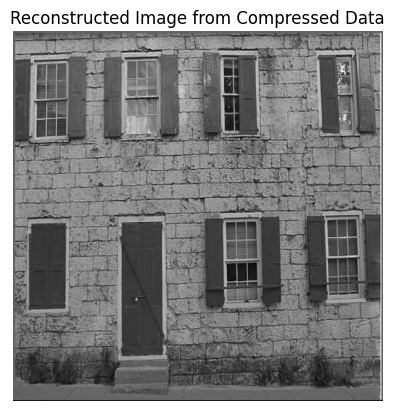

In [16]:
from scipy.fftpack import idct

def inverse_quantization(quantized_blocks, quant_table):
    return np.array([block * quant_table for block in quantized_blocks]) # Multiply each quantized block by the quantization table

def inverse_dct(reconstructed_blocks):
    return np.array([idct(idct(block.T, norm='ortho').T, norm='ortho') for block in reconstructed_blocks]) # Apply inverse DCT to each block

def reconstruct_image_from_blocks(blocks, image_shape=(512, 512)):
    # Reassemble the blocks into the original image
    block_size = blocks.shape[1]
    image = np.zeros(image_shape)
    idx = 0
    for i in range(0, image_shape[0], block_size):
        for j in range(0, image_shape[1], block_size):
            image[i:i + block_size, j:j + block_size] = blocks[idx]
            idx += 1
    return np.clip(image, 0, 255).astype(np.uint8)

def save_as_jpeg(image, reconstructed_filename):
    pil_image = Image.fromarray(image)  # Convert numpy array to PIL Image
    pil_image.save(reconstructed_filename, "JPEG")
    print(f"Reconstructed image saved as {reconstructed_filename}")


# Step 1: Inverse quantization
reconstructed_blocks = inverse_quantization(decoded_quantized_blocks, scaled_table)

# Step 2: Inverse DCT
spatial_blocks = inverse_dct(reconstructed_blocks)

# Step 3: Reconstruct the image
reconstructed_image = reconstruct_image_from_blocks(spatial_blocks)

# Step 4: Save the reconstructed Image
save_as_jpeg(reconstructed_image, reconstructed_filename)


# Display the reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image from Compressed Data")
plt.axis("off")
plt.show()

# Step 7: Analyzing Reconstruction Quality

To evaluate the quality of the reconstructed image, we calculate metrics like the **Root Mean Squared Error (RMSE)** between the original and reconstructed image. This gives us a sense of how much information was lost during compression.

## Calculating RMSE

The **Root Mean Squared Error (RMSE)** between the original image \( I_{\text{orig}} \) and the reconstructed image \( I_{\text{recon}} \) is given by the following formula:

\[
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (I_{\text{orig}}[i] - I_{\text{recon}}[i])^2}
\]

Where:
- \( N \) is the total number of pixels in the image.
- \( I_{\text{orig}}[i] \) is the pixel value at the \( i \)-th position of the original image.
- \( I_{\text{recon}}[i] \) is the pixel value at the \( i \)-th position of the reconstructed image.

This metric allows us to measure how close the reconstructed image is to the original one, with lower RMSE indicating better reconstruction quality.


In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_rmse(original_image, reconstructed_image):
    rmse = np.sqrt(mean_squared_error(original_image.flatten(), reconstructed_image.flatten()))
    return rmse

# Calculate RMSE for a single image
rmse = calculate_rmse(images, reconstructed_image)
print(f"RMSE for the reconstructed image: {rmse:.4f}")

RMSE for the reconstructed image: 6.4049


In [18]:
def rmse_vs_bpp_analysis(images, encoded_data):
    # original_size_bits = images.size * 8  # Total bits in original images
    encoded_size_bits = len(encoded_data)  # Compressed size in bits
    bpp = encoded_size_bits / (images.shape[0] * images.shape[1] )  # Bits per pixel
    
    decoded_symbols = decode_data(encoded_data, huffman_tree)
    decoded_blocks = rebuild_quantized_blocks(decoded_symbols)
    reconstructed_blocks = inverse_quantization(decoded_blocks, scaled_table)
    spatial_blocks = inverse_dct(reconstructed_blocks)
    reconstructed_image = reconstruct_image_from_blocks(spatial_blocks)
    
    rmse = calculate_rmse(images, reconstructed_image)
    
    return bpp, rmse

bpp, rmse = rmse_vs_bpp_analysis(images, encoded_data)
print(f"Bits Per Pixel (BPP): {bpp:.4f}")
print(f"RMSE: {rmse:.4f}")


Bits Per Pixel (BPP): 1.8174
RMSE: 6.4049


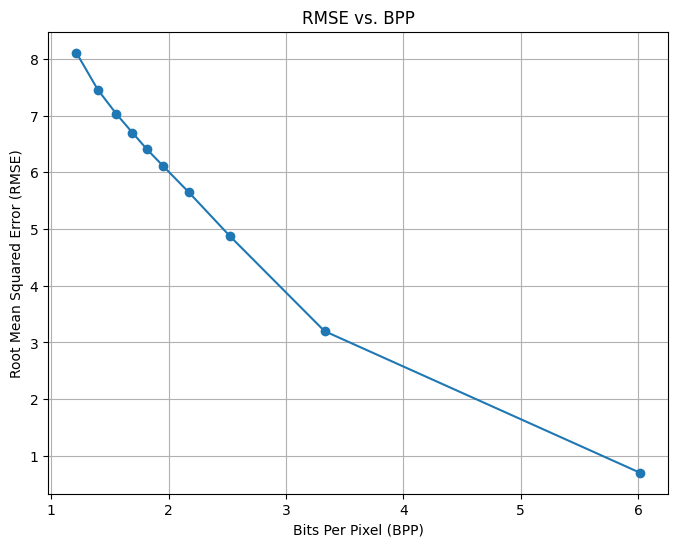

In [20]:
import matplotlib.pyplot as plt

def plot_rmse_vs_bpp(quality_factors, bpps, rmses, plot_filename):
    plt.figure(figsize=(8, 6))
    plt.plot(bpps, rmses, marker='o')
    plt.title("RMSE vs. BPP")
    plt.xlabel("Bits Per Pixel (BPP)")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.grid(True)
    plt.savefig(plot_filename)
    plt.show()

# (simulate RMSE and BPP values for different quality factors)
quality_factors = range(10, 101, 10)
# np.linspace(5, 100, 25)  # Quality factors
bpps = []  
rmses = [] 


for qf in quality_factors:
    scaled_table = scale_quantization_table(default_quantization_table, qf)
    all_quantized_blocks = quantize_dct(dct_blocks, scaled_table)
    encoded_data, huffman_tree, huffman_codes = huffman_encode(all_quantized_blocks)
    bpp, rmse = rmse_vs_bpp_analysis(images, encoded_data)
    bpps.append(bpp)
    rmses.append(rmse)

plot_rmse_vs_bpp(quality_factors, bpps, rmses, plot_filename)

In [20]:
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image
# from scipy.fftpack import idct

# def decode_and_reconstruct_image(encoded_data, huffman_tree, quant_table, image_shape=(512, 512)):
#     # Decode the bitstream into quantized coefficients
#     decoded_symbols = decode_data(encoded_data, huffman_tree)

#     # Rebuild quantized blocks from decoded symbols
#     decoded_quantized_blocks = rebuild_quantized_blocks(decoded_symbols)

#     # Perform inverse quantization
#     reconstructed_blocks = inverse_quantization(decoded_quantized_blocks, quant_table)

#     # Apply inverse DCT to get spatial blocks
#     spatial_blocks = inverse_dct(reconstructed_blocks)

#     # Reconstruct the full image from blocks
#     reconstructed_image = reconstruct_image_from_blocks(spatial_blocks, image_shape)

#     return reconstructed_image

# Define functions for compression and decompression (based on previous code)

# def save_compressed_data(encoded_data, huffman_tree, filename):
#     with open(filename, 'wb') as f:
#         pickle.dump({
#             "huffman_tree": huffman_tree,
#             "encoded_data": encoded_data
#         }, f)
#     print(f"Compressed data saved to {filename}")

# def load_compressed_data(filename):
#     with open(filename, 'rb') as f:
#         data = pickle.load(f)
#     return data["encoded_data"], data["huffman_tree"]

# def decode_data(encoded_data, huffman_tree):
#     decoded_symbols = []
#     current_node = huffman_tree
#     for bit in encoded_data:
#         current_node = current_node.left if bit == '0' else current_node.right
#         if current_node.symbol is not None:
#             decoded_symbols.append(current_node.symbol)
#             current_node = huffman_tree
#     return decoded_symbols

# def rebuild_quantized_blocks(decoded_symbols, block_shape=(8, 8), num_blocks=4096):
#     quantized_blocks = [np.array(decoded_symbols[i * 64:(i + 1) * 64]).reshape(block_shape) for i in range(num_blocks)]
#     return np.array(quantized_blocks)

# def inverse_quantization(quantized_blocks, quant_table):
#     return np.array([block * quant_table for block in quantized_blocks])

# def inverse_dct(reconstructed_blocks):
#     return np.array([idct(idct(block.T, norm='ortho').T, norm='ortho') for block in reconstructed_blocks])

# def reconstruct_image_from_blocks(blocks, image_shape=(512, 512)):
#     image = np.zeros(image_shape)
#     idx = 0
#     block_size = blocks.shape[1]
#     for i in range(0, image_shape[0], block_size):
#         for j in range(0, image_shape[1], block_size):
#             image[i:i + block_size, j:j + block_size] = blocks[idx]
#             idx += 1
#     return np.clip(image, 0, 255).astype(np.uint8)

# def save_as_jpeg(image, filename="reconstructed_image.jpg"):
#     pil_image = Image.fromarray(image)  # Convert numpy array to PIL Image
#     pil_image.save(filename, "JPEG")
#     print(f"Reconstructed image saved as {filename}")

# def display_image(image):
#     plt.imshow(image, cmap='gray')
#     plt.title("Reconstructed Image from Compressed Data")
#     plt.axis("off")
#     plt.show()

# --- Main Execution ---
# Step 1: Save the compressed data (Huffman tree + encoded bitstream)
# save_compressed_data(encoded_data, huffman_tree, "compressed_image.bin")

# Step 2: Load the compressed data (Huffman tree + encoded bitstream)
# encoded_data, huffman_tree = load_compressed_data("compressed_image.bin")

# Step 3: Decode and reconstruct the image
# reconstructed_image = decode_and_reconstruct_image(encoded_data, huffman_tree, scaled_table)

# Step 4: Save the reconstructed image as a JPEG file
# save_as_jpeg(reconstructed_image, "reconstructed_image.jpg")

# # Optional: Display the image if desired
# display_image(reconstructed_image)


********************************************************************************************************************************************************
Analysis of Image: kodim01.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 58.37 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.58
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_01_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 67.32 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 5.70
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_01_qf20.png
For Quality Factor: 30
Original Image Size: 

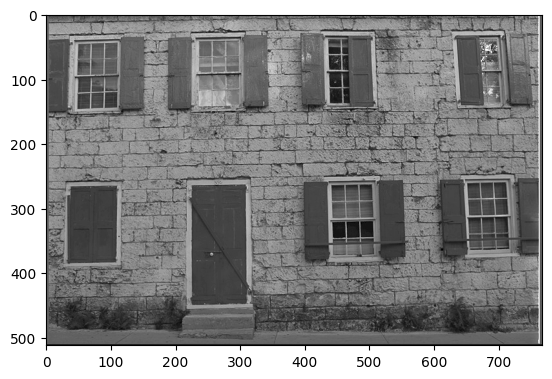

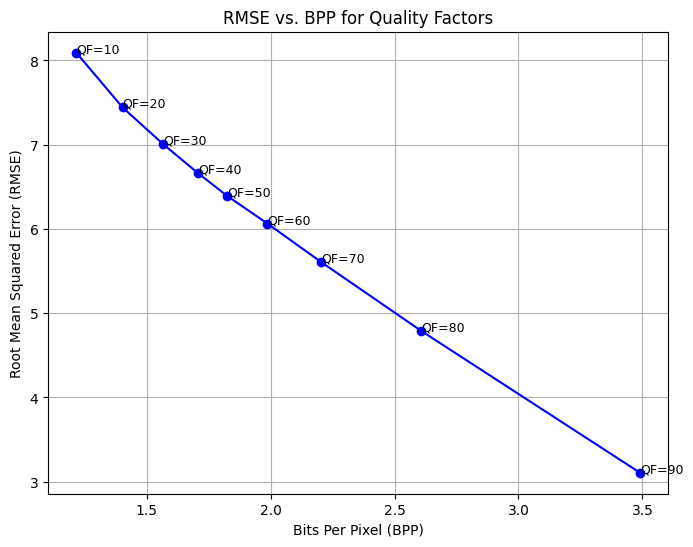

********************************************************************************************************************************************************
Analysis of Image: kodim02.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 52.23 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 7.35
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_02_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 55.76 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.89
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_02_qf20.png
For Quality Factor: 30
Original Image Size: 

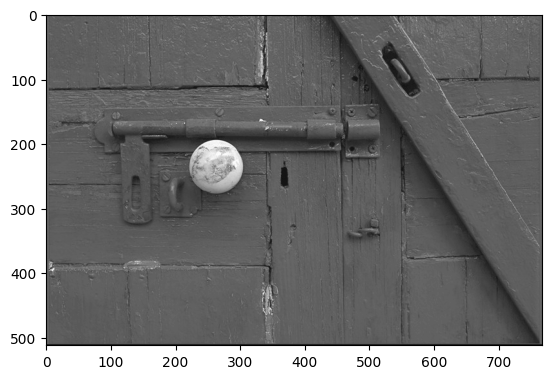

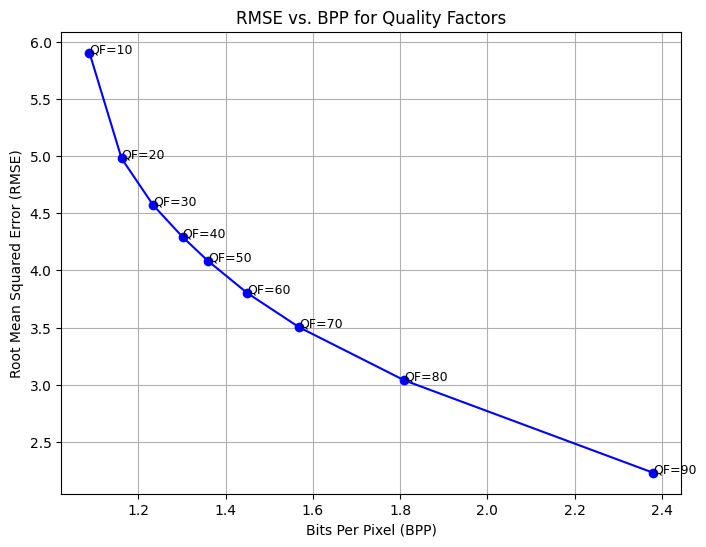

********************************************************************************************************************************************************
Analysis of Image: kodim03.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 53.96 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 7.12
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_03_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 57.77 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.65
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_03_qf20.png
For Quality Factor: 30
Original Image Size: 

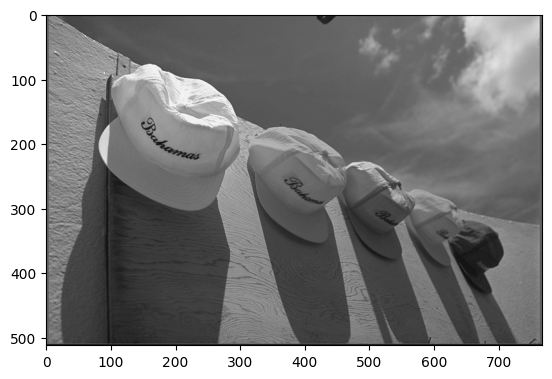

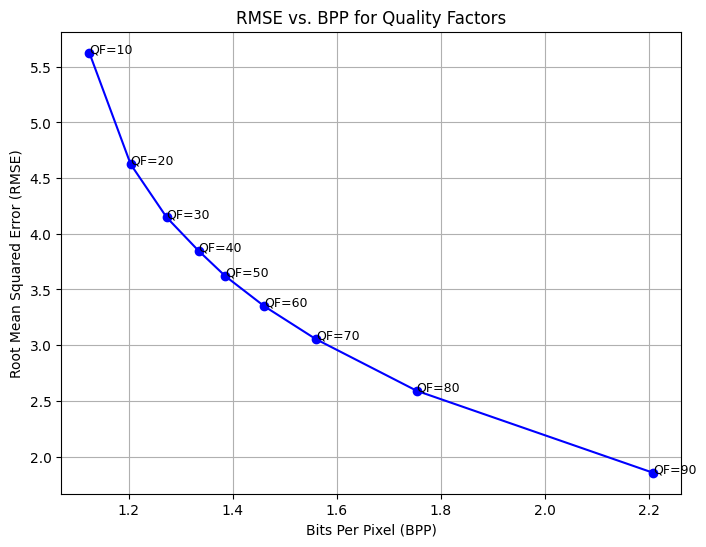

********************************************************************************************************************************************************
Analysis of Image: kodim04.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 54.14 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 7.09
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_04_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 58.69 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.54
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_04_qf20.png
For Quality Factor: 30
Original Image Size: 

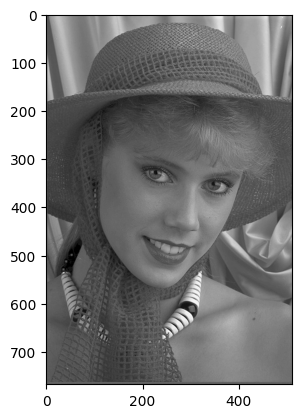

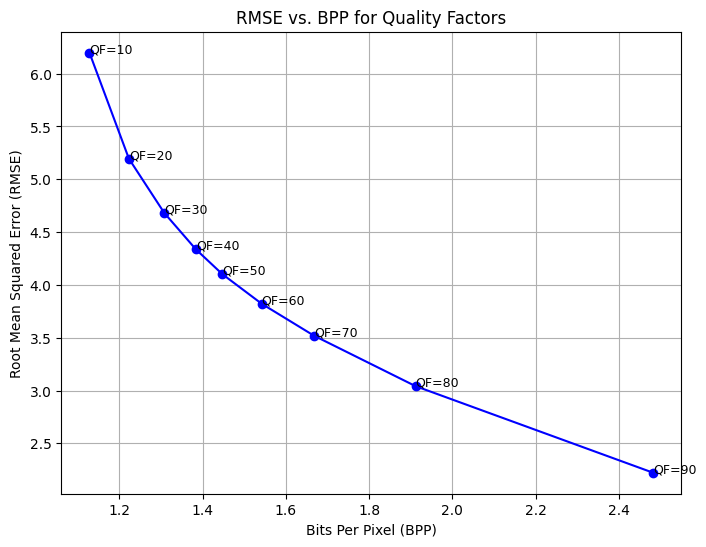

********************************************************************************************************************************************************
Analysis of Image: kodim05.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 60.62 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.34
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_05_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 71.03 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 5.41
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_05_qf20.png
For Quality Factor: 30
Original Image Size: 

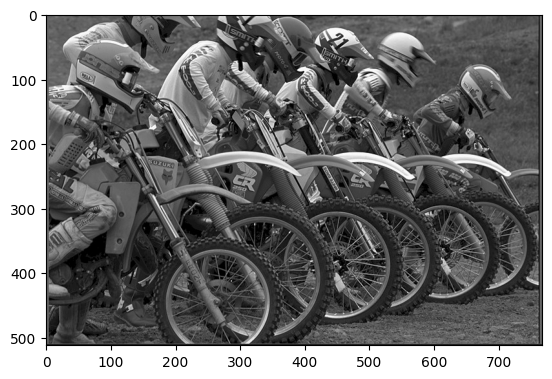

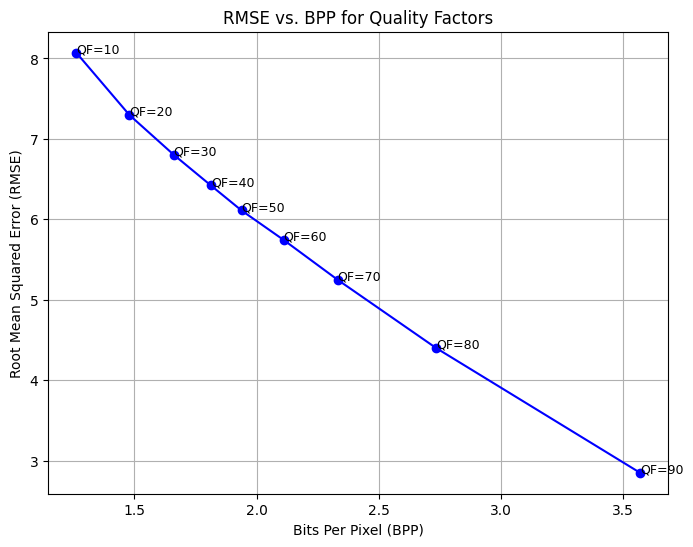

********************************************************************************************************************************************************
Analysis of Image: kodim06.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 56.86 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.75
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_06_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 63.94 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.01
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_06_qf20.png
For Quality Factor: 30
Original Image Size: 

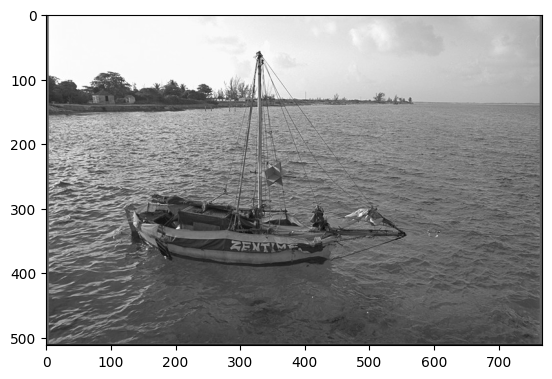

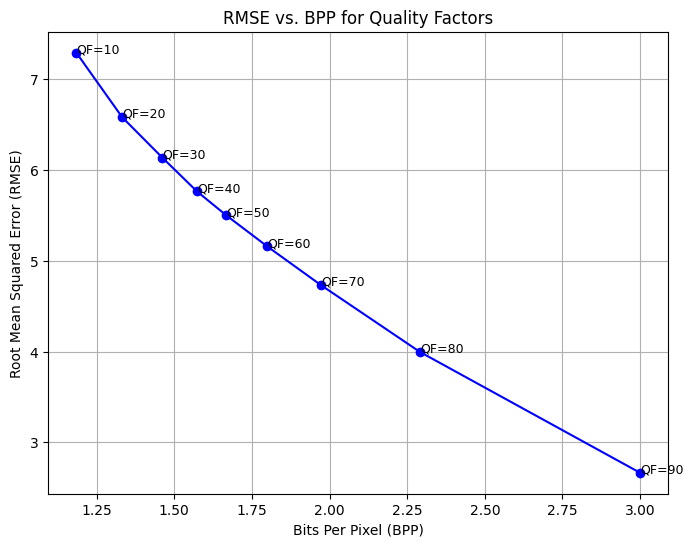

********************************************************************************************************************************************************
Analysis of Image: kodim07.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 55.92 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.87
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_07_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 61.16 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.28
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_07_qf20.png
For Quality Factor: 30
Original Image Size: 

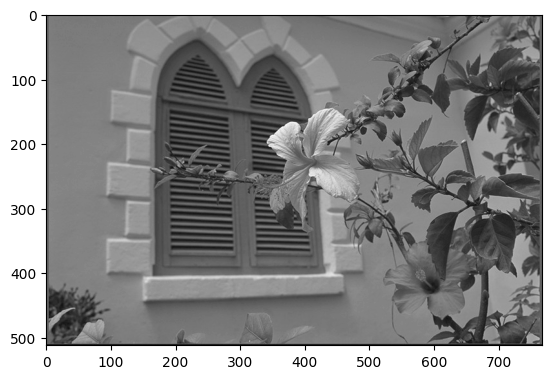

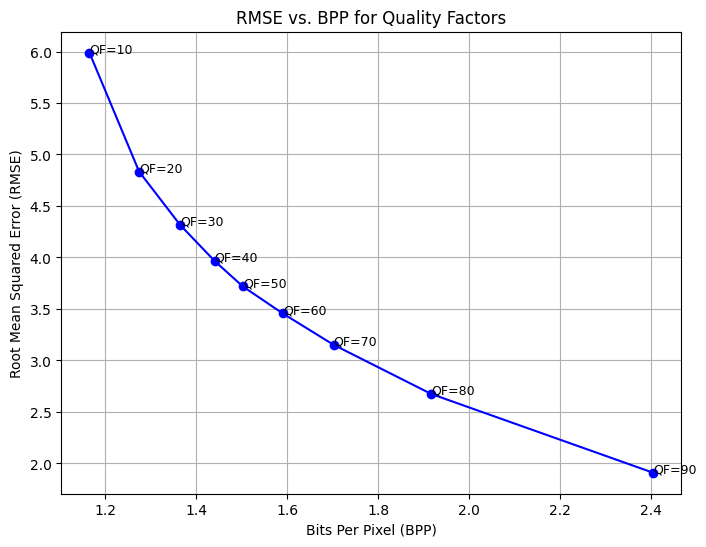

********************************************************************************************************************************************************
Analysis of Image: kodim08.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 61.72 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.22
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_08_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 71.77 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 5.35
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_08_qf20.png
For Quality Factor: 30
Original Image Size: 

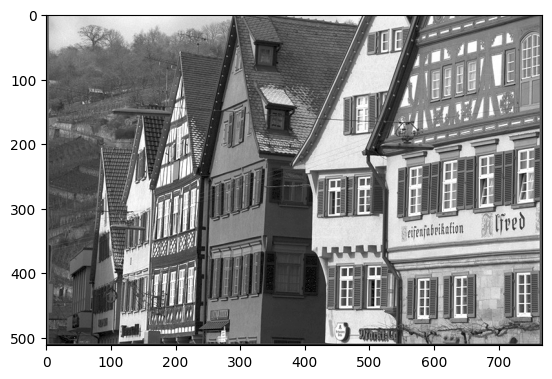

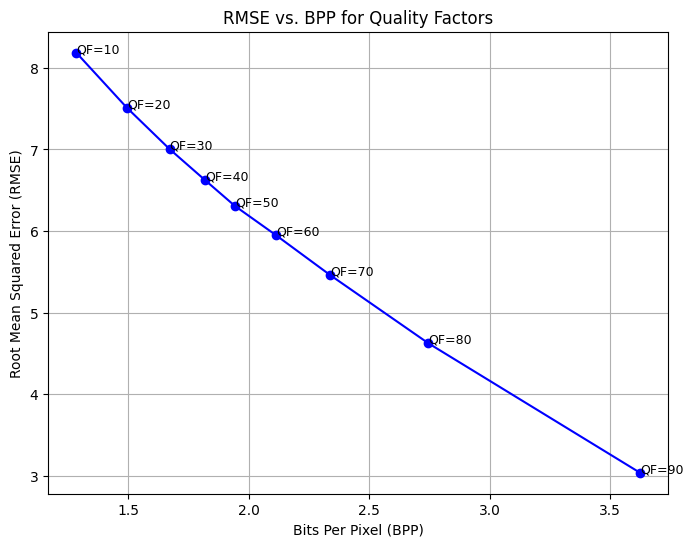

********************************************************************************************************************************************************
Analysis of Image: kodim09.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 54.85 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 7.00
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_09_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 59.07 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.50
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_09_qf20.png
For Quality Factor: 30
Original Image Size: 

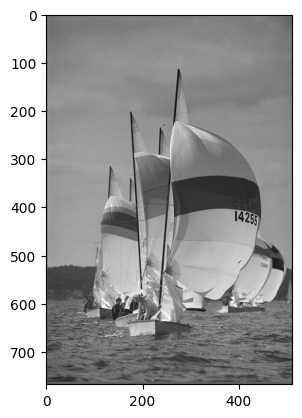

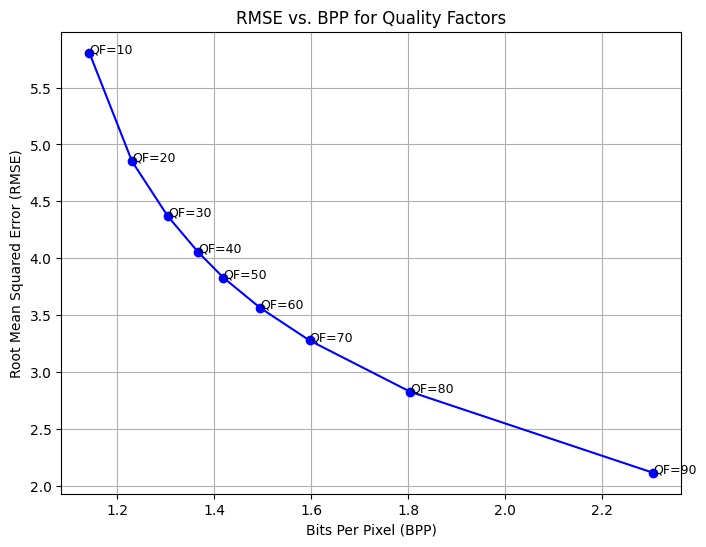

********************************************************************************************************************************************************
Analysis of Image: kodim10.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 54.88 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 7.00
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_10_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 59.53 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.45
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_10_qf20.png
For Quality Factor: 30
Original Image Size: 

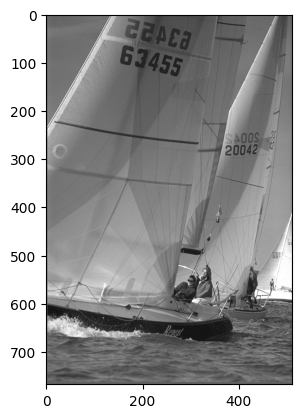

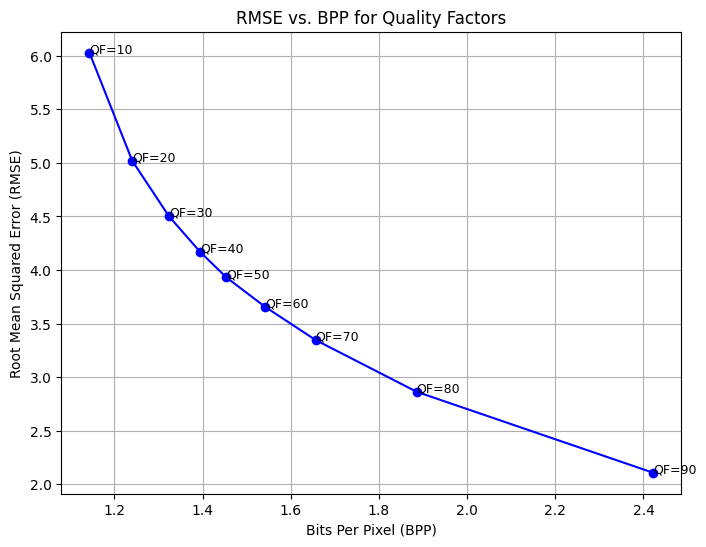

********************************************************************************************************************************************************
Analysis of Image: kodim11.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 55.35 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.94
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_11_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 61.50 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.24
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_11_qf20.png
For Quality Factor: 30
Original Image Size: 

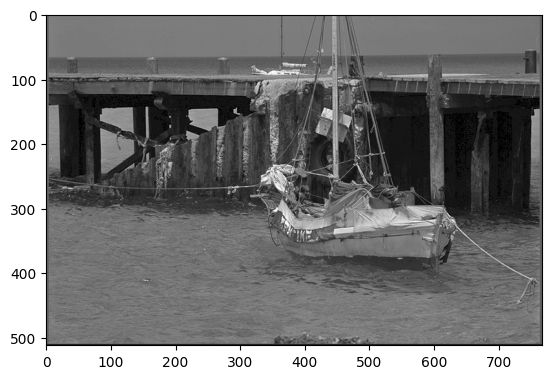

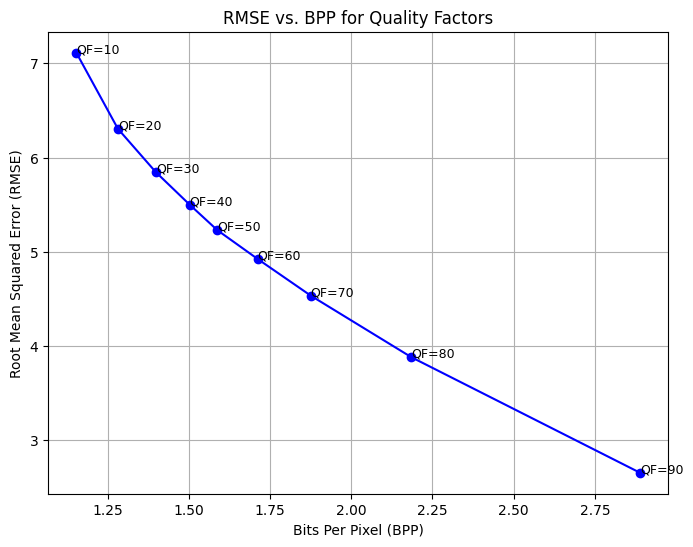

********************************************************************************************************************************************************
Analysis of Image: kodim12.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 53.97 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 7.11
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_12_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 57.84 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.64
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_12_qf20.png
For Quality Factor: 30
Original Image Size: 

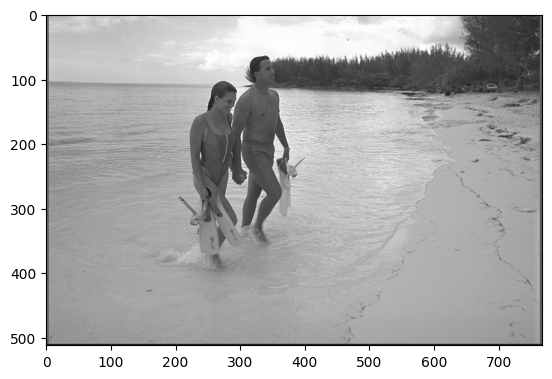

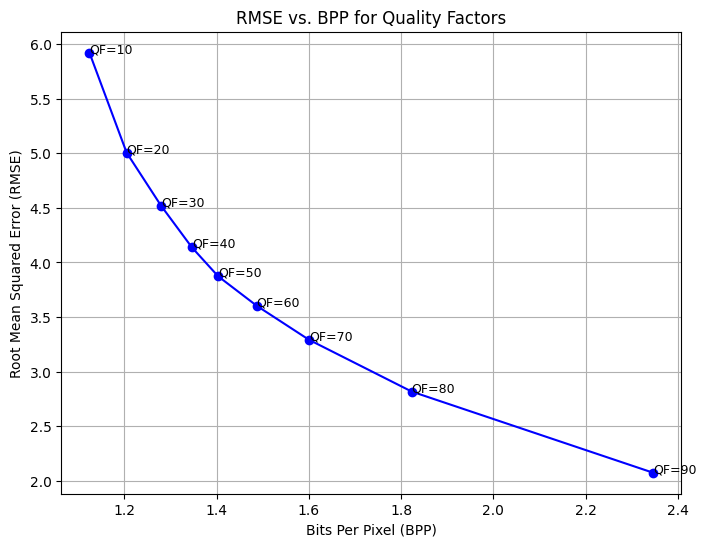

********************************************************************************************************************************************************
Analysis of Image: kodim13.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 60.69 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.33
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_13_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 71.98 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 5.33
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_13_qf20.png
For Quality Factor: 30
Original Image Size: 

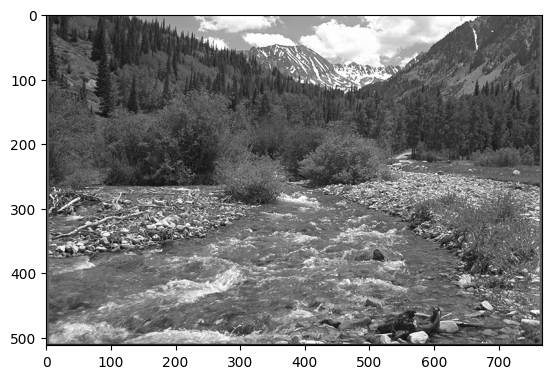

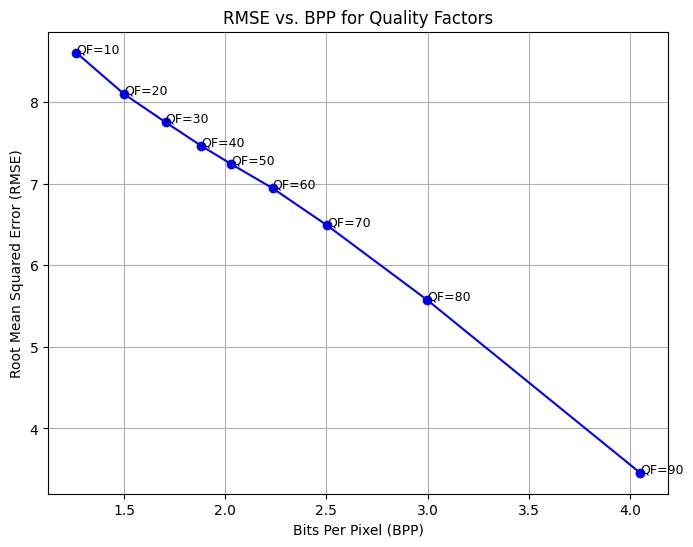

********************************************************************************************************************************************************
Analysis of Image: kodim14.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 57.34 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.70
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_14_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 65.35 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 5.88
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_14_qf20.png
For Quality Factor: 30
Original Image Size: 

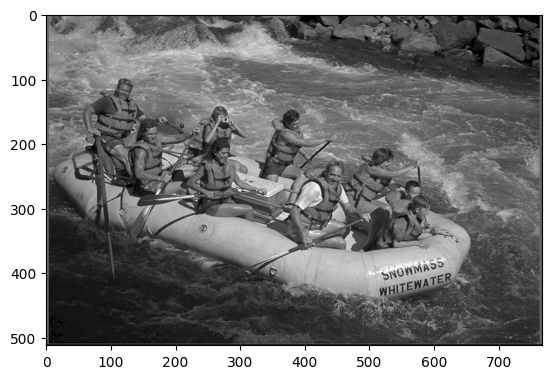

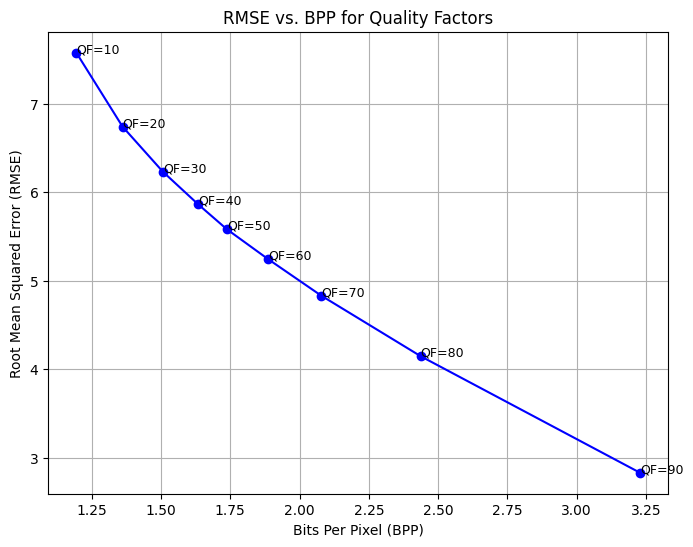

********************************************************************************************************************************************************
Analysis of Image: kodim15.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 54.73 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 7.02
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_15_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 59.17 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.49
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_15_qf20.png
For Quality Factor: 30
Original Image Size: 

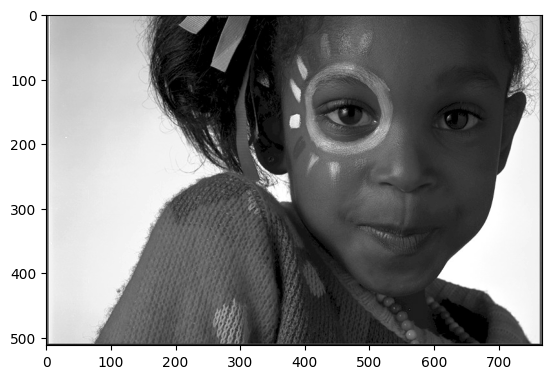

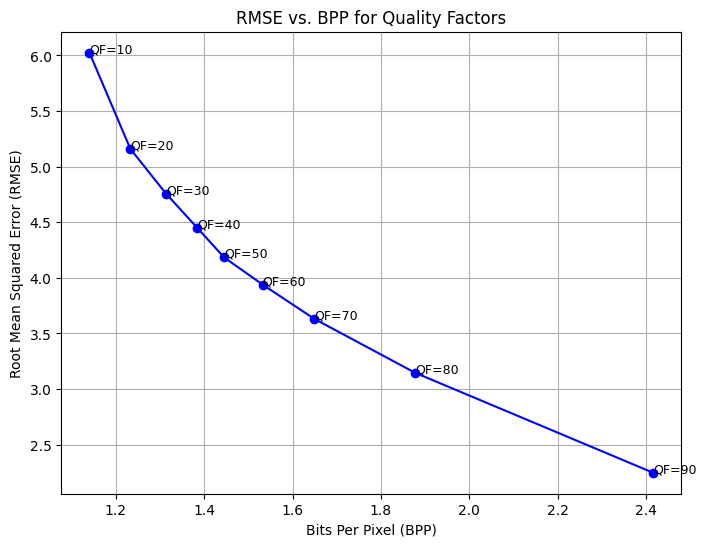

********************************************************************************************************************************************************
Analysis of Image: kodim16.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 54.24 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 7.08
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_16_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 59.35 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.47
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_16_qf20.png
For Quality Factor: 30
Original Image Size: 

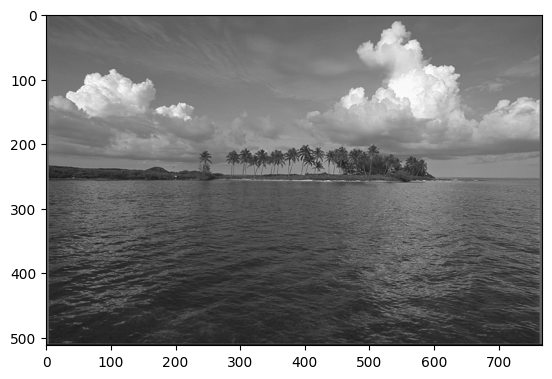

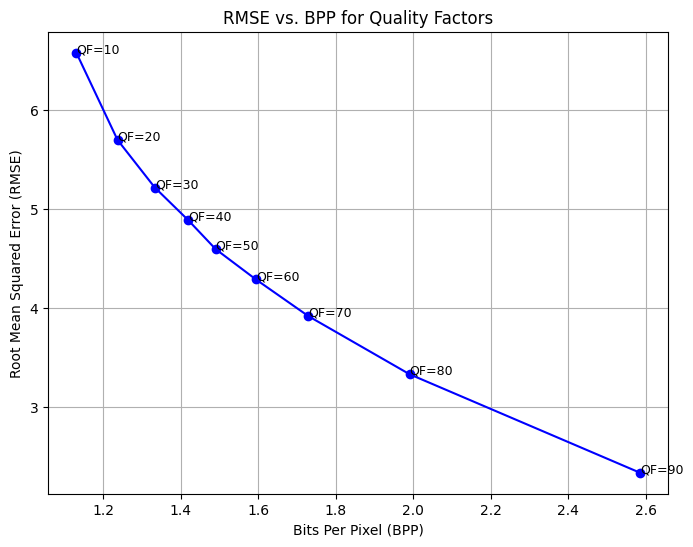

********************************************************************************************************************************************************
Analysis of Image: kodim17.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 54.96 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.99
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_17_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 60.42 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.36
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_17_qf20.png
For Quality Factor: 30
Original Image Size: 

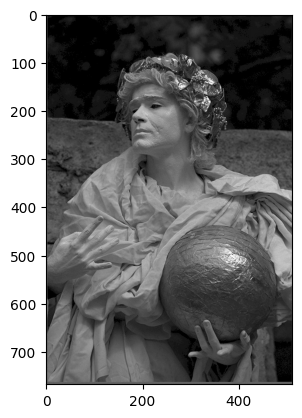

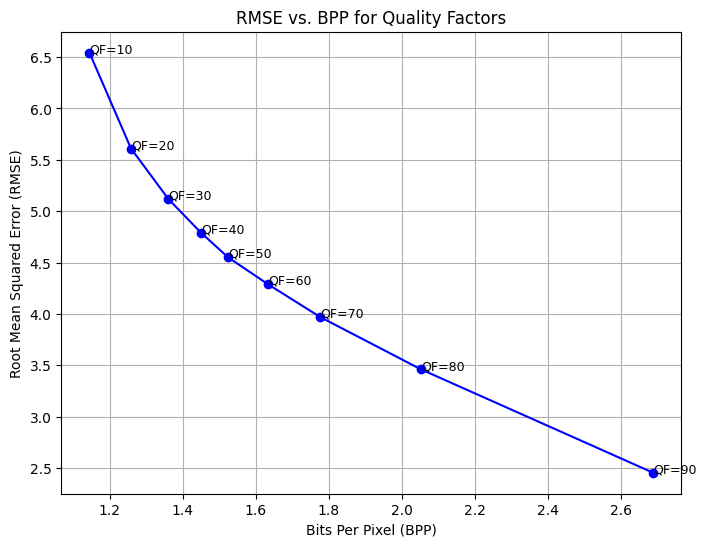

********************************************************************************************************************************************************
Analysis of Image: kodim18.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 56.92 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.75
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_18_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 64.73 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 5.93
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_18_qf20.png
For Quality Factor: 30
Original Image Size: 

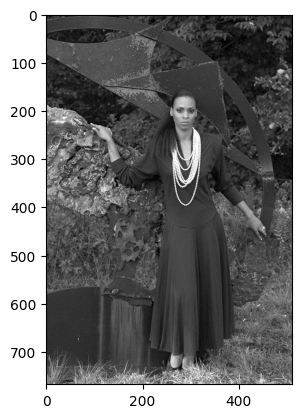

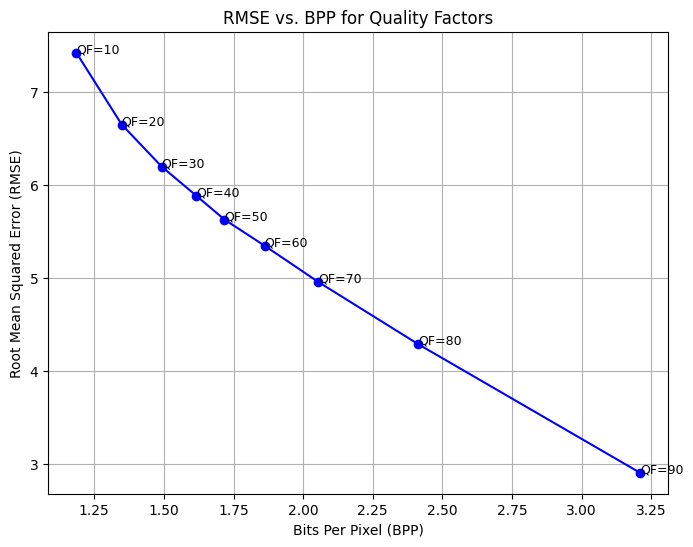

********************************************************************************************************************************************************
Analysis of Image: kodim19.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 55.87 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.87
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_19_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 61.60 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.23
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_19_qf20.png
For Quality Factor: 30
Original Image Size: 

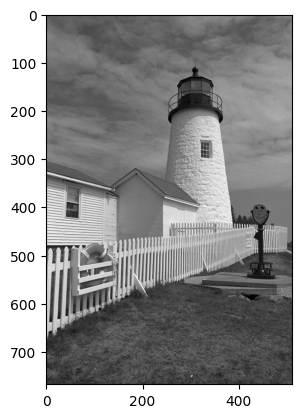

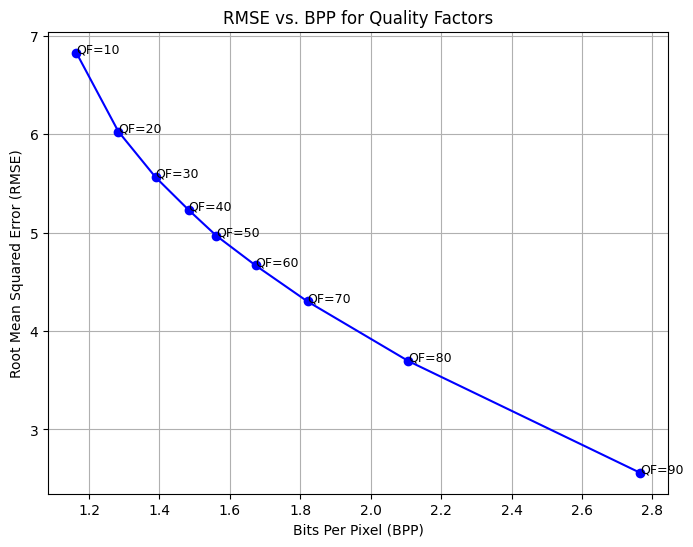

********************************************************************************************************************************************************
Analysis of Image: kodim20.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 54.63 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 7.03
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_20_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 58.72 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.54
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_20_qf20.png
For Quality Factor: 30
Original Image Size: 

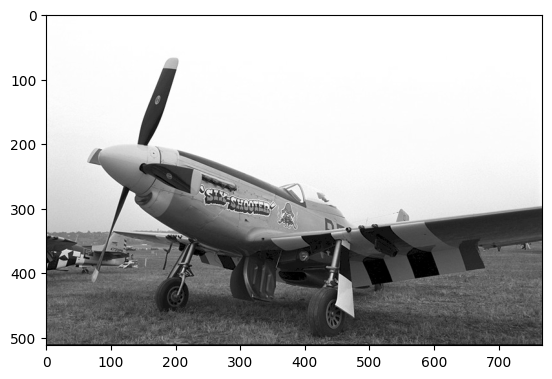

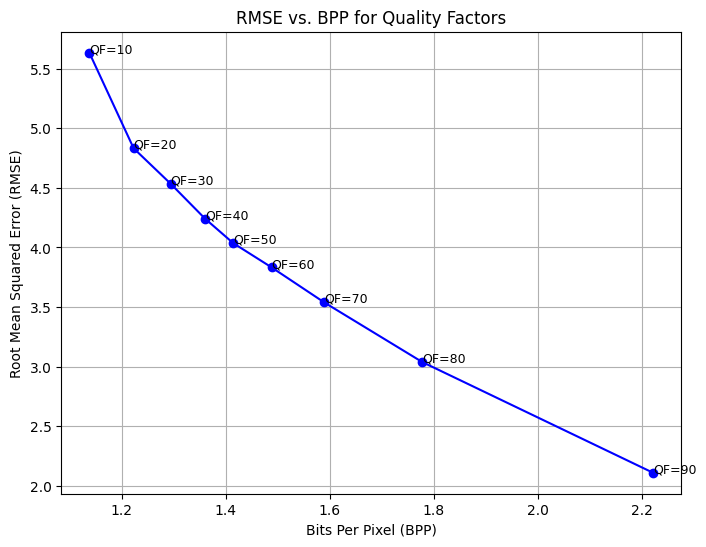

********************************************************************************************************************************************************
Analysis of Image: kodim21.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 56.46 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.80
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_21_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 62.85 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.11
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_21_qf20.png
For Quality Factor: 30
Original Image Size: 

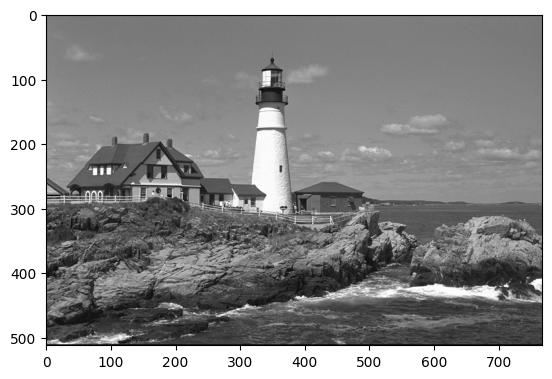

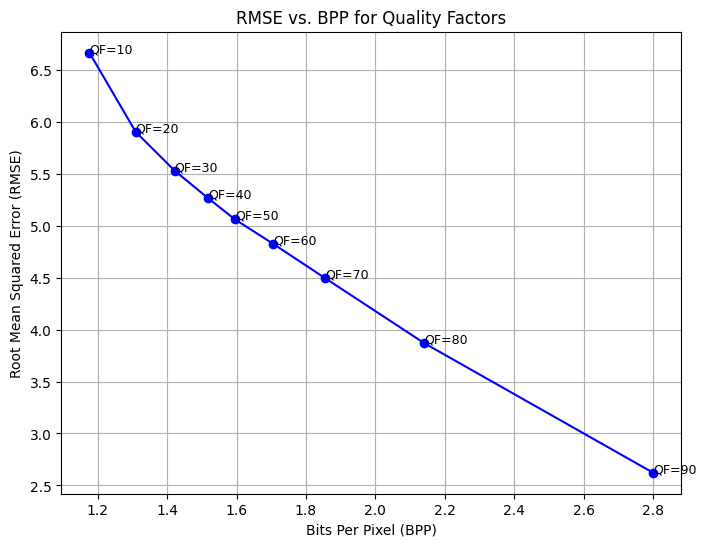

********************************************************************************************************************************************************
Analysis of Image: kodim22.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 55.07 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.97
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_22_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 60.92 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.30
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_22_qf20.png
For Quality Factor: 30
Original Image Size: 

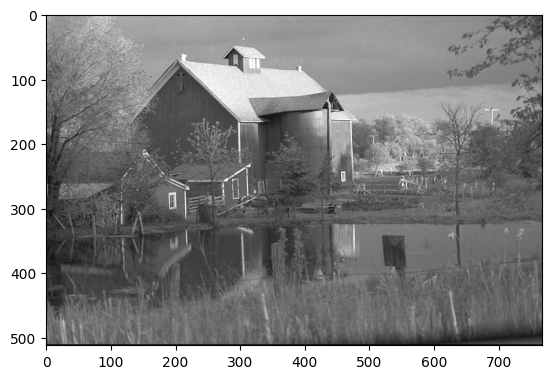

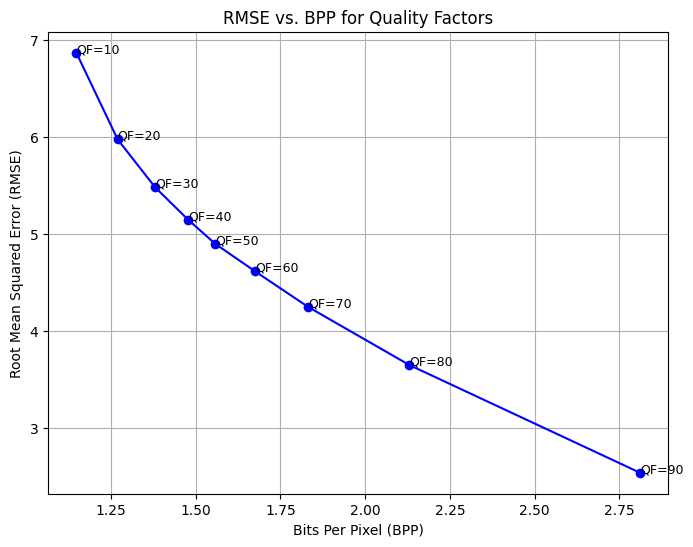

********************************************************************************************************************************************************
Analysis of Image: kodim23.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 54.05 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 7.10
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_23_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 57.58 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.67
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_23_qf20.png
For Quality Factor: 30
Original Image Size: 

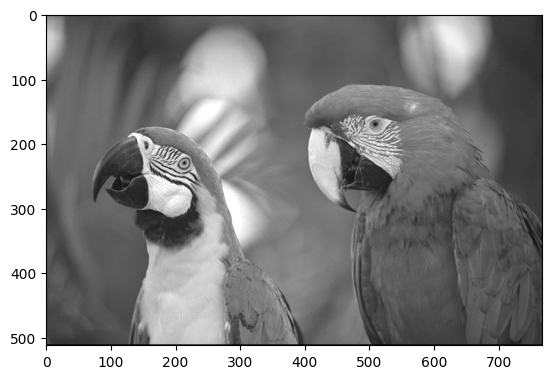

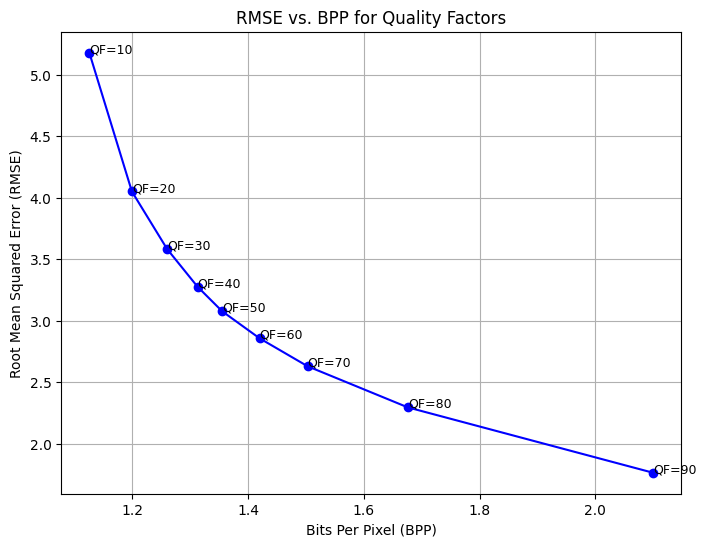

********************************************************************************************************************************************************
Analysis of Image: kodim24.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 57.57 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 6.67
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_24_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 65.29 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 5.88
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_images/reconstruct_img_rle_24_qf20.png
For Quality Factor: 30
Original Image Size: 

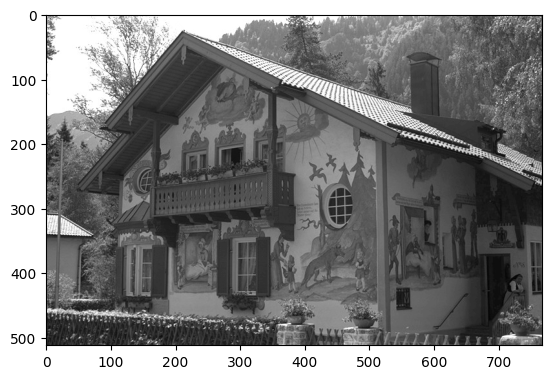

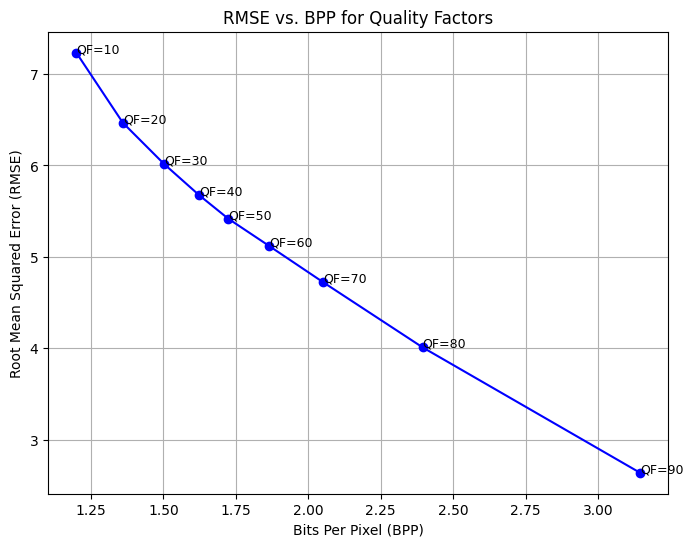

In [27]:
# import os
# import cv2
# import numpy as np
# from scipy.fftpack import dct, idct
# from collections import Counter
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt
# import heapq
# from PIL import Image

# # Quantization table for luminance (Y)
# QY = np.array([
#     [16, 11, 10, 16, 24, 40, 51, 61],
#     [12, 12, 14, 19, 26, 58, 60, 55],
#     [14, 13, 16, 24, 40, 57, 69, 56],
#     [14, 17, 22, 29, 51, 87, 80, 62],
#     [18, 22, 37, 56, 68, 109, 103, 77],
#     [24, 35, 55, 64, 81, 104, 113, 92],
#     [49, 64, 78, 87, 103, 121, 120, 101],
#     [72, 92, 95, 98, 112, 100, 103, 99]
# ])


# # Huffman Encoding
# class HuffmanNode:
#     def __init__(self, value=None, frequency=0, left=None, right=None):
#         self.value = value
#         self.frequency = frequency
#         self.left = left
#         self.right = right

#     def __lt__(self, other):
#         return self.frequency < other.frequency

# def build_huffman_tree(frequency_table):
#     heap = [HuffmanNode(value, freq) for value, freq in frequency_table.items()]
#     heapq.heapify(heap)
    
#     while len(heap) > 1:
#         left = heapq.heappop(heap)
#         right = heapq.heappop(heap)
#         merged = HuffmanNode(frequency=left.frequency + right.frequency, left=left, right=right)
#         heapq.heappush(heap, merged)
    
#     return heap[0]

# def generate_huffman_codes(node, prefix="", codebook={}):
#     if node.value is not None:
#         codebook[node.value] = prefix
#     else:
#         generate_huffman_codes(node.left, prefix + "0", codebook)
#         generate_huffman_codes(node.right, prefix + "1", codebook)
#     return codebook

# def huffman_encode(data):
#     frequency_table = Counter(data)
#     root = build_huffman_tree(frequency_table)
#     codebook = generate_huffman_codes(root)
#     encoded_data = "".join(codebook[value] for value in data)
#     return encoded_data, codebook

# def huffman_decode(encoded_data, codebook):
#     reverse_codebook = {v: k for k, v in codebook.items()}
#     decoded_data = []
#     buffer = ""
#     for bit in encoded_data:
#         buffer += bit
#         if buffer in reverse_codebook:
#             decoded_data.append(reverse_codebook[buffer])
#             buffer = ""
#     return decoded_data

# # RMSE Calculation
# def calculate_rmse(original_image, reconstructed_image):
#     rmse = np.sqrt(mean_squared_error(original_image.flatten(), reconstructed_image.flatten()))
#     return rmse

# # JPEG Compression Functions
# def split_into_blocks(image, block_size=8):
#     h, w = image.shape
#     return [image[i:i+block_size, j:j+block_size] for i in range(0, h, block_size) for j in range(0, w, block_size)]

# def apply_dct(blocks):
#     return [dct(dct(block.T, norm='ortho').T, norm='ortho') for block in blocks]

# def quantize(blocks, quant_matrix):
#     return [np.round(block / quant_matrix).astype(np.int32) for block in blocks]

# def dequantize(blocks, quant_matrix):
#     return [block * quant_matrix for block in blocks]
  
# def apply_idct(blocks):
#     return [idct(idct(block.T, norm='ortho').T, norm='ortho') for block in blocks]

# def merge_blocks(blocks, image_shape, block_size=8):
#     h, w = image_shape
#     image = np.zeros((h, w))
#     idx = 0
#     for i in range(0, h, block_size):
#         for j in range(0, w, block_size):
#             image[i:i+block_size, j:j+block_size] = blocks[idx]
#             idx += 1
#     return image

# def jpeg_compression_grayscale(image, quality_factor=50):
#     scale = 50 / quality_factor if quality_factor < 50 else 2 - quality_factor / 50
#     qy = np.clip(QY * scale, 1, 255).astype(np.int32)
#     blocks = split_into_blocks(image)
#     dct_blocks = apply_dct(blocks)
#     quantized_blocks = quantize(dct_blocks, qy)
#     return quantized_blocks, qy, image.shape

# def jpeg_decompression_grayscale(quantized_blocks, quant_matrix, original_shape):
#     dequantized_blocks = [block * quant_matrix for block in quantized_blocks]
#     idct_blocks = apply_idct(dequantized_blocks)
#     decompressed_image = merge_blocks(idct_blocks, original_shape)
#     return np.clip(decompressed_image, 0, 255).astype(np.uint8)

# def save_compressed_data(encoded_data, codebook, quant_matrix, filename="compressed_image_norle.bin"):
#     import pickle
#     with open(filename, 'wb') as f:
#         pickle.dump({
#             'encoded_data': encoded_data,
#             'codebook': codebook,
#             'quant_matrix': quant_matrix
#         }, f)

# import pickle

# def load_compressed_data(filename="compressed_image_norle.bin"):
#     with open(filename, 'rb') as f:
#         return pickle.load(f)

# def save_as_jpeg(image, reconstructed_filename, qf):
#     pil_image = Image.fromarray(image)  # Convert numpy array to PIL Image
#     reconstructed_filename = reconstructed_filename.replace(".png", f"_qf{qf}.png")
#     pil_image.save(reconstructed_filename, "JPEG")
#     print(f"Reconstructed image saved as {reconstructed_filename}")

# def calculate_sizes_and_ratios(images, encoded_data, qf):
#     # Image size (Original)
#     height, width = images.shape
#     original_size_bits = height * width * 8  # 8 bits per pixel
#     dct_size_bits = height * width * 32  # 32 bits per coefficient
#     quantized_size_bits = height * width * 16  # 16 bits per coefficient
#     encoded_size_bits = len(encoded_data)  # Size of the compressed bitstream
    
#     # Compression Ratios
#     dct_ratio = original_size_bits / dct_size_bits
#     quantized_ratio = original_size_bits / quantized_size_bits
#     encoded_ratio = original_size_bits / encoded_size_bits
#     print("======================================================================")
#     print(f"For Quality Factor: {qf}")
#     print(f"Original Image Size: {original_size_bits / 8 / 1024:.2f} KB")
#     print(f"DCT Coefficients Size: {dct_size_bits / 8 / 1024:.2f} KB")
#     print(f"Quantized Coefficients Size: {quantized_size_bits / 8 / 1024:.2f} KB")
#     print(f"Encoded Data Size: {encoded_size_bits / 8 / 1024:.2f} KB")
    
#     print("\nCompression Ratios:")
#     print(f"Original to DCT Ratio: {dct_ratio:.2f}")
#     print(f"Original to Quantized Ratio: {quantized_ratio:.2f}")
#     print(f"Original to Encoded Ratio: {encoded_ratio:.2f}")


# # RMSE vs BPP Analysis
# def rmse_vs_bpp_analysis(image, quality_factors, save_path, reconstruct_img_save_path):
#     bpps = []
#     rmses = []

#     for qf in quality_factors:
#         quantized_blocks, quant_matrix, img_shape = jpeg_compression_grayscale(image, quality_factor=qf)
#         flattened_data = flatten_quantized_blocks(quantized_blocks)
#         encoded_data, codebook = huffman_encode(flattened_data)
        
#         calculate_sizes_and_ratios(image, encoded_data, qf)

#         reconstructed_image = jpeg_decompression_grayscale(quantized_blocks, quant_matrix, img_shape)

#         # cv2.imshow('Compressed Grayscale Image', reconstructed_image)
#         plt.imshow(reconstructed_image, cmap='gray')
#         save_as_jpeg(reconstructed_image, reconstruct_img_save_path, qf)

#         # Calculate RMSE and BPP
#         rmse = calculate_rmse(image, reconstructed_image)
#         bpp = len(encoded_data) / (image.shape[0] * image.shape[1])
#         rmses.append(rmse)
#         bpps.append(bpp)
    
#     # Plot and save graph
#     plt.figure(figsize=(8, 6))
#     plt.plot(bpps, rmses, marker='o', linestyle='-', color='b')  # Plot BPP vs RMSE
#     for i, qf in enumerate(quality_factors):
#         plt.text(bpps[i], rmses[i], f'QF={qf}', fontsize=9, ha='left', color='black')

#     plt.title(f"RMSE vs. BPP for Quality Factors")
#     plt.xlabel("Bits Per Pixel (BPP)")
#     plt.ylabel("Root Mean Squared Error (RMSE)")
#     plt.grid(True)
#     plt.savefig(save_path)
#     plt.show()

# # Main Execution
# image_folder = f"/home/ssaral/Downloads/CS663_Project/img/"
# output_folder = "/home/ssaral/Downloads/CS663_Project/compressed_images/"
# quality_factors = range(10, 100, 10)

# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# for img_file in sorted(os.listdir(image_folder)):
#     if img_file.endswith(".png"):
#         image_id = img_file[5:7]
#         img_path = os.path.join(image_folder, img_file)
#         image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
#         if image is None:
#             print(f"Failed to load image: {img_file}")
#             continue
#         print("********************************************************************************************************************************************************")
#         print(f"Analysis of Image: {img_file}")
#         graph_save_path = os.path.join(output_folder, f"rmse_bpp_{image_id}.png")
#         reconstruct_img_save_path = os.path.join(output_folder, f"reconstruct_img_{image_id}.png")
#         rmse_vs_bpp_analysis(image, quality_factors, graph_save_path, reconstruct_img_save_path)
        
